In [1]:
!pip install redis
!pip install wordcloud
from os import chdir
chdir('../')
%matplotlib inline
from lib import *
suppress_warnings()

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
conn, cur = conpg(location = 'postgres')
sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags from tweets
                  where (date_time >= NOW() - '7 day'::INTERVAL);'''

cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)

In [3]:
r = conrds()
r.keys()

[b'crackit',
 b'tweet_tfidf_fit_transform',
 b'tweets_tfd_svd_pipe',
 b'tweet_tfidf_fit']

In [4]:
tfd_svd_pipe = pickle.loads(r.get('tweets_tfd_svd_pipe'))

In [5]:
TFIDF_fit =  tfd_svd_pipe.steps[0][1]
SVD_fit = tfd_svd_pipe.steps[1][1]

In [6]:
def event_tweet_count(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    return len(event_tweet)

In [7]:
def tweets_event_ab_test(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True)
    
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)
    
    n = int(round((event_tweet_count(event))*0.2,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())
    
    A1 = event_tweet.iloc[A1_index,:]
    A1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A1['cleaned_tweet']])

    A2 = event_tweet.iloc[A_index,:] 
    #A2.reset_index(inplace = True)
    A2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A2['cleaned_tweet']])
    non_event_tweet = df[~df['cleaned_tweet'].str.contains(('event'))]
    non_event_tweet.reset_index(inplace = True)
    
    B_index = list(range(non_event_tweet.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
    m = A2.shape[0]
    B2_index = []
    for i in range(m):
        B2_index.append(B_index.pop())  
    
    B1 = non_event_tweet.iloc[B1_index,:]
    B1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B1['cleaned_tweet']])
    
    B2 = non_event_tweet.iloc[B2_index,:]
    B2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B2['cleaned_tweet']])
    
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)
    B1_vec_mean = np.mean(B1_vec, axis=0)
    B2_vec_mean = np.mean(B2_vec, axis=0)
    
    a1a2 = cosine_similarity(A1_vec_mean.reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0]
    b1b2 = cosine_similarity(B2_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a1b1 = cosine_similarity(A1_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a2b2 = cosine_similarity(A2_vec_mean.reshape(1,-1),B2_vec_mean.reshape(1,-1))[0][0]
   
    a2_consim_list = []
    for i in range(min(n,m)):  
        a2_consim_list.append(cosine_similarity(A2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0])
    a2_mean = np.mean(np.array(a2_consim_list))
    a2_std = np.std(np.array(a2_consim_list))
    
    b2_consim_list = []
    for i in range(min(n,m)):  
        b2_consim_list.append(cosine_similarity(B2_vec[i].reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0])
    b2_mean = np.mean(b2_consim_list)
    b2_std = np.std(b2_consim_list)
    
    a1b2_consim_list = []
    for i in range(min(n,m)):  
        a1b2_consim_list.append((cosine_similarity(B2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0]))
    a1b2_mean = np.mean(a1b2_consim_list)
    a1b2_std = np.std(a1b2_consim_list)
    print('Cosine Similarity')
    print('\t[A1_mean|A2_mean] : ',round(a1a2,3),'\t|\tmean of [A1_mean|A2] :',round(a2_mean,3), \
                                  '\t|\tSTD of [A1_mean|A2] :', round(a2_std,3), '\n',
          '\t[B1_mean|B2_mean] : ',round(b1b2,3), '\t|\tmean of [B1_mean|B2] :', round(b2_mean,3), \
                                   '\t|\tSTD of [B1_mean|B2] :', round(b2_std,3), '\n',
          '\t[A1_mean|B2_mean] : ', round(a2b2,3), '\t|\tmean of [A1_mean|B2] :', round(a1b2_mean,3),\
                                    '\t|\tSTD of [A1_mean|B2] :', round(a1b2_std,3)) 
    plt.figure(figsize=(16,8))
    plt.scatter(range(len(a2_consim_list)), a2_consim_list, c = 'g', label = 'cosine similarity of A vectors')
    plt.scatter(range(len(b2_consim_list)), b2_consim_list, c = 'r', label = 'cosine similarity of B vectors')    
    plt.legend(fontsize = 20)
    plt.show()
    
    sns.plt.figure(figsize=(16,8))
    sns.distplot(a2_consim_list,color='g',label = 'cosine similarity of A vectors')
    sns.distplot(b2_consim_list,color='r', label = 'cosine similarity of B vectors')
    sns.plt.legend(fontsize = 20)
    sns.plt.show()
    
    
    component_1 = np.argsort(SVD_fit.explained_variance_ratio_)[::-1][0]
    component_2 = np.argsort(SVD_fit.explained_variance_ratio_)[::-1][1]
    plt.figure(figsize=(16,8))
    plt.scatter(B1_vec.T[component_1], B1_vec.T[component_2], facecolor="red", alpha=.7,marker='^', s = 100, label = 'B1 Vector')
    plt.scatter(B2_vec.T[component_1], B2_vec.T[component_2], facecolor="red", alpha=0.5,marker='x', s = 100, label = 'B2 Vector')
    plt.scatter(A2_vec.T[component_1], A2_vec.T[component_2], facecolor="green", alpha=0.5,marker='x', s = 100, label = 'A2 Vector')
    plt.scatter(A1_vec.T[component_1], A1_vec.T[component_2], facecolor="green", alpha=.7,marker='^', s = 100, label = 'A1 Vector')
    plt.legend(fontsize = 20)
    plt.show()
    #plt.xlim(-.2,1)
    #plt.ylim(-.2,1)
    
    # this is another inset axes over the main axes
    #a = plt.axes([0.5, 0.5, .45, .45], facecolor='y', alpha=.4)
    #plt.scatter(B1_vec.T[component_1], B1_vec.T[component_2], facecolor="red", alpha=.7,marker='^', s = 100)
    #plt.scatter(A1_vec.T[component_1], A1_vec.T[component_2], facecolor="green", alpha=.7,marker='^', s = 100)
    #plt.scatter(B2_vec.T[component_1], B2_vec.T[component_2], facecolor="red", alpha=0.5,marker='x', s = 100)
    #plt.scatter(A2_vec.T[component_1], A2_vec.T[component_2], facecolor="green", alpha=0.5,marker='x', s = 100)
    #plt.title('subplot')
    #plt.xlim(-.2, 0.2)
    #plt.xlim(-.2, 0.2)
    #plt.xticks([])
    #plt.yticks([])
    return a2_consim_list, b2_consim_list

In [8]:
def check_score_cluster(event,check_by_score = .7,high_score = .9):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True, drop=True)
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)

    n = int(round((event_tweet_count(event))*0.5,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())

    A1 = event_tweet.iloc[A1_index,:]
    A1.reset_index(inplace = True, drop=True)
    A1_vec = SVD_fit.transform(TFIDF_fit.transform(A1['cleaned_tweet']))

    A2 = event_tweet.iloc[A_index,:] 
    A2_vec = SVD_fit.transform(TFIDF_fit.transform(A2['cleaned_tweet']))
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)

    consim_twt_list = []
    for i in range(len(A1)):  
        consim_twt_list.append((cosine_similarity(A1_vec[i].reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0], A1['cleaned_tweet'][i]))
    #pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster1 = result[result['score']>high_score].sort_values('score', ascending = False)
    cluster2 = result[((result['score']<(check_by_score+.05)) & (result['score']>(check_by_score-.05)))]\
                .sort_values('score', ascending = False)
    return pd.concat([cluster1.reset_index().head(30), cluster2.reset_index().head(30)], axis=1)

In [9]:
def Top_scored_tweets_in_B(event, n = 10000):
    event = event.lower()
    A = df[df['cleaned_tweet'].str.contains((event))]
    A.reset_index(inplace = True, drop=True)
    A_vec = SVD_fit.transform(TFIDF_fit.transform(A['cleaned_tweet']))
    A_vec_mean = np.average(A_vec, axis=0)
       
    B = df[~df['cleaned_tweet'].str.contains((event))]
    B_index = list(range(B.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
        
    B1 = B.iloc[B1_index,:]
    B1.reset_index(inplace = True, drop=True)
    B1_vec = SVD_fit.transform(TFIDF_fit.transform(B1['cleaned_tweet']))
    
    consim_twt_list = []
    for i in range(n):  
        consim_twt_list.append((cosine_similarity(B1_vec[i].reshape(1,-1),A_vec_mean.reshape(1,-1))[0][0], B1['cleaned_tweet'][i]))
    pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster = result[result['score']>.7].sort_values('score', ascending = False)
    pd.set_option('display.max_colwidth', -1)
    return cluster.head(20)

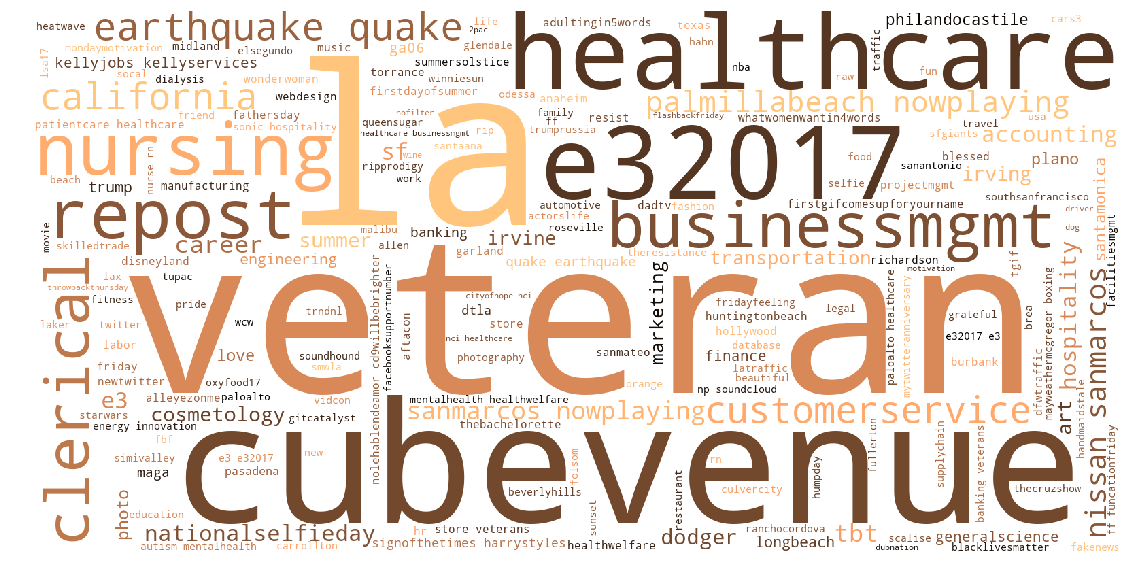

In [16]:
words = df['hashtags'][(df['hashtags'].isnull() == False) & (df['hashtags'] != 'None')]
stopwords = set(STOPWORDS)
stopwords.add("job")
stopwords.add("careerarc")
stopwords.add("hiring")
stopwords.add("dallas")
stopwords.add("losangeles")
stopwords.add("sanfrancisco")
stopwords.add("jobs")
stopwords.add("sacramento")
stopwords.add("retail")
stopwords.add("sale")
stopwords.add("sales")
wc = WordCloud(width=1600, height=800, background_color='white', \
               relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in words))


plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

Event Tweets (earthquake|quake):  677
Cosine Similarity
	[A1_mean|A2_mean] :  0.996 	|	mean of [A1_mean|A2] : 0.769 	|	STD of [A1_mean|A2] : 0.299 
 	[B1_mean|B2_mean] :  0.964 	|	mean of [B1_mean|B2] : 0.297 	|	STD of [B1_mean|B2] : 0.126 
 	[A1_mean|B2_mean] :  0.325 	|	mean of [A1_mean|B2] : 0.11 	|	STD of [A1_mean|B2] : 0.147


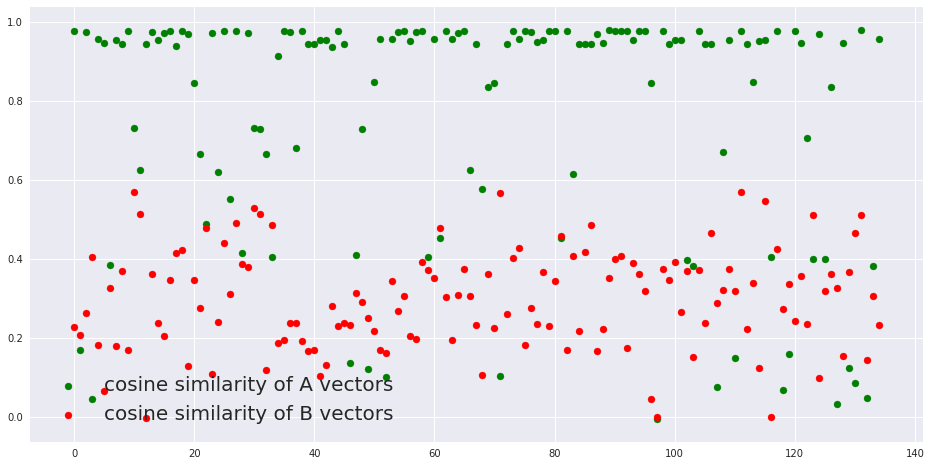

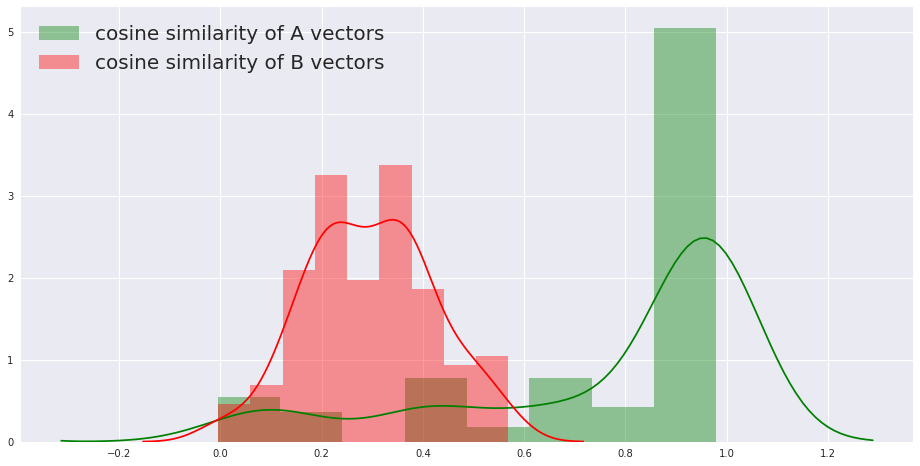

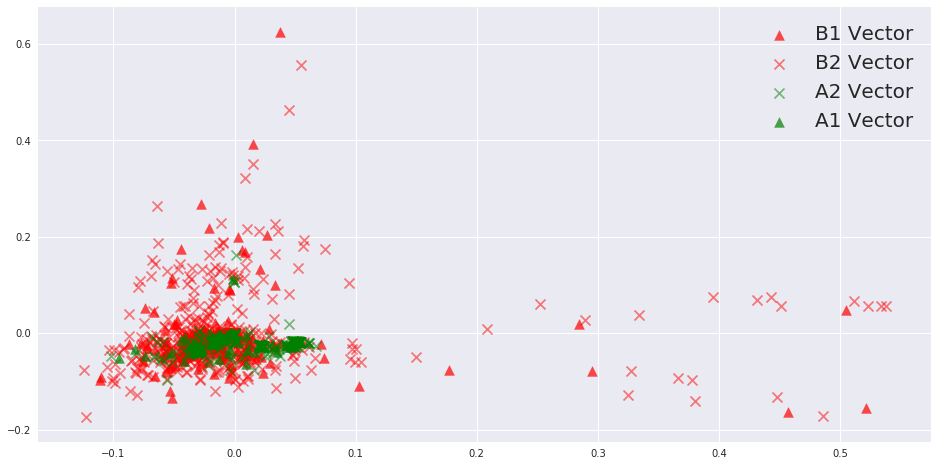

In [11]:
print('Event Tweets (earthquake|quake): ', event_tweet_count('earthquake|quake'))
A, B = tweets_event_ab_test('earthquake|quake')

In [12]:
#check high score tweets (>0.9) versus tweets with clustered scores 
check_score_cluster('earthquake|quake',.4)

,index,score,tweet,index,score,tweet
0,187,0.978863,usgs reports a m #earthquake 28km e of king ci...,224,0.449863,please check out a new earthquake simulator g...
1,57,0.978863,usgs reports a m #earthquake 28km e of king ci...,81,0.449024,please check out a new earthquake simulator g...
2,154,0.978189,usgs reports a m1.74 #earthquake 6km n of big ...,125,0.449024,please check out a new earthquake simulator g...
3,76,0.977535,usgs reports a m1.24 #earthquake 7km se of yuc...,52,0.439533,"1.6 magnitude #earthquake. 10 km from niland, ..."
4,236,0.977189,usgs reports a m1.45 #earthquake 4km sw of idy...,244,0.435820,1.7 magnitude #earthquake. 16 km from #mammoth...
5,38,0.977189,usgs reports a m1.45 #earthquake 4km sw of idy...,122,0.435460,3.4 magnitude #earthquake. 16 mi from westmorl...
6,47,0.977081,usgs reports a m1.59 #earthquake 14km ssw of s...,316,0.429499,1.7 magnitude #earthquake. 11 km from #aguanga...
7,14,0.976909,usgs reports a m1.36 #earthquake 25km nw of di...,256,0.426644,1.7 magnitude #earthquake. 14 km from mammoth ...
8,297,0.976884,usgs reports a m1.38 #earthquake 3km n of weld...,327,0.426433,1.6 magnitude #earthquake. 2 km from mammoth l...
9,296,0.976819,usgs reports a m0.65 #earthquake 13km ssw of m...,217,0.423084,2.6 magnitude #earthquake. 18 km from #mammoth...


Event Tweets (e32017):  855
Cosine Similarity
	[A1_mean|A2_mean] :  0.979 	|	mean of [A1_mean|A2] : 0.442 	|	STD of [A1_mean|A2] : 0.148 
 	[B1_mean|B2_mean] :  0.95 	|	mean of [B1_mean|B2] : 0.302 	|	STD of [B1_mean|B2] : 0.118 
 	[A1_mean|B2_mean] :  0.841 	|	mean of [A1_mean|B2] : 0.269 	|	STD of [A1_mean|B2] : 0.138


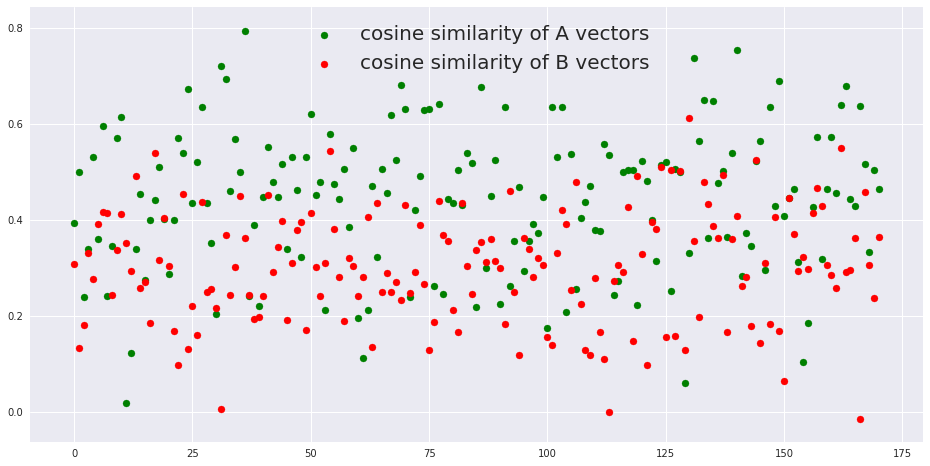

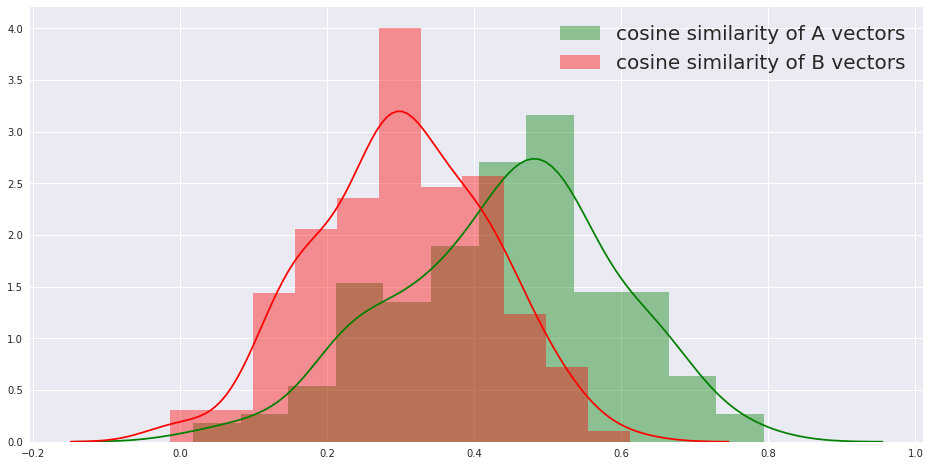

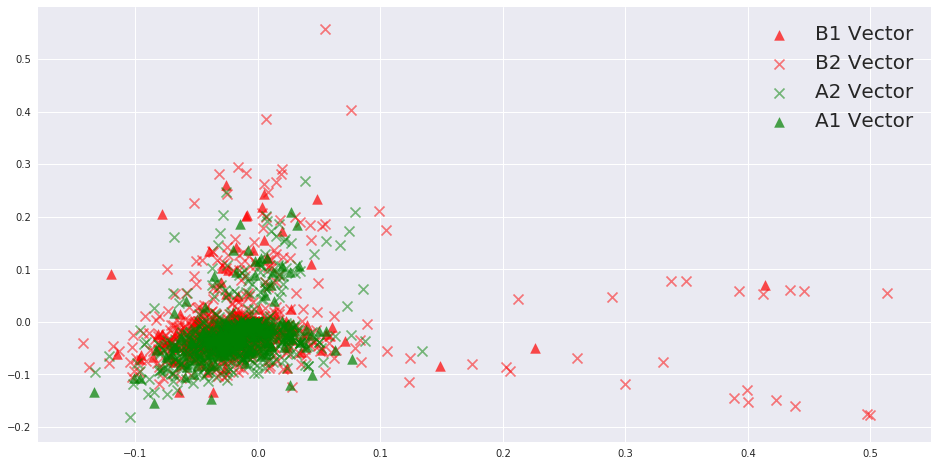

In [13]:
print('Event Tweets (e32017): ', event_tweet_count('e32017'))
A, B = tweets_event_ab_test('e32017')

In [14]:
Top_scored_tweets_in_B('e32017', n = 300000)

,score,tweet
277388,0.824306,[8:12 a.m.]a system error occurred during event movement. a system error occurred during event movement.
275572,0.822066,top shelf after party @ casa del mar
214772,0.817335,"antes de ir hacia el aeropuerto, mis favs del e3. 5. forza 7 4. spidey 3. monster hunter world 2. dragon ball fighterz 1. mario odyssey"
74308,0.807330,bsg party @ blue screen gaming
235556,0.797495,#ubie3 after party
173966,0.794990,free game
230493,0.784420,#coxeagles 2017 2nd grade mrs. schlosser's musical biomes. post performance.
288281,0.783788,"teaching online pedagogical repository (topr) call 4 submissions open through september 15, 2017 #opensunycotenews"
104959,0.783248,super summer disc golf giveaway! win a pro-picked disc golf set worth over $500 from #discgolf
231739,0.781957,post wedding pool party @ eagle mountain lake
